In [1]:
import torch
import torch.nn as nn
import torch.utils.data

import torchvision
from torchvision import transforms

In [14]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [2]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize(0.5,0.5)
])

In [ ]:
MNIST_dataset = torchvision.datasets.MNIST(root = '../../data/',
                                           train = True,
                                           transform=transform,
                                           download=True
                                           )

In [168]:
batch_size = 256

data_loader = torch.utils.data.DataLoader(MNIST_dataset,
                                          batch_size = batch_size,
                                          shuffle = True,
                                          drop_last=True)

In [172]:
class Discrminator(nn.Module):
    def __init__(self):
        super(Discrminator,self).__init__()

        self.linear = nn.Sequential(
            nn.Linear(28*28 , 1024),
            nn.LeakyReLU(0.2),
            nn.Linear(1024,512),
            nn.LeakyReLU(0.2),
            nn.Linear(512,256),
            nn.LeakyReLU(0.2),
            nn.Linear(256,1),
            nn.Sigmoid()
        )

    def forward(self,x):
        return self.linear(x)

class Generator(nn.Module):
    def __init__(self):
        super(Generator,self).__init__()

        self.linear = nn.Sequential(
            nn.Linear(100 , 256),
            nn.ReLU(),
            nn.Linear(256,512),
            nn.ReLU(),
            nn.Linear(512,1024),
            nn.ReLU(),
            nn.Linear(1024,28*28),
            nn.Tanh()
        )

    def forward(self,x):
        return self.linear(x)

In [173]:
discrminator = Discrminator()
generator = Generator()

discrminator = discrminator.to(device)
generator = generator.to(device)

In [170]:
criterion = nn.BCELoss()
d_optimizer = torch.optim.Adam(discrminator.parameters(),lr = 2e-4)
g_optimizer = torch.optim.Adam(generator.parameters(),lr = 2e-4)

In [77]:
for epoch in range(200):
    print(f"epoch : {epoch} : ",end = " ")
    for i , (img,label) in enumerate(data_loader):
        
        real_label = torch.full((batch_size,1),1,dtype=torch.float32).to(device)
        fake_label = torch.full((batch_size,1),0,dtype=torch.float32).to(device)

        real_img = img.reshape(batch_size,-1).to(device)

        g_optimizer.zero_grad()
        d_optimizer.zero_grad()

        z = torch.randn(batch_size,100).to(device)
        fake_img = generator(z)

        g_loss = criterion(discrminator(fake_img),real_label)
        
        g_loss.backward()
        g_optimizer.step()

        d_optimizer.zero_grad()
        g_optimizer.zero_grad()

        z = torch.randn(256,100).to(device)
        fake_img = generator(z)

        fake_loss = criterion(discrminator(fake_img),fake_label)
        real_loss = criterion(discrminator(real_img),real_label)
        d_loss = (fake_loss + real_loss) / 2

        d_loss.backward()
        d_optimizer.step()

        if i == 100:
            print(f"d_loss = {d_loss.item()} , g_loss = {g_loss.item()}")



epoch : 0 :  d_loss = 0.1946977823972702 , g_loss = 1.6097874641418457
epoch : 1 :  d_loss = 0.1358182728290558 , g_loss = 7.182331562042236
epoch : 2 :  d_loss = 0.09441863000392914 , g_loss = 7.12978982925415
epoch : 3 :  d_loss = 0.0030741372611373663 , g_loss = 7.970882415771484
epoch : 4 :  d_loss = 0.2547873854637146 , g_loss = 17.005855560302734
epoch : 5 :  d_loss = 0.18936869502067566 , g_loss = 3.215116262435913
epoch : 6 :  d_loss = 0.08354794234037399 , g_loss = 3.072118043899536
epoch : 7 :  d_loss = 0.07327205687761307 , g_loss = 4.4917497634887695
epoch : 8 :  d_loss = 0.3225044012069702 , g_loss = 1.4853661060333252
epoch : 9 :  d_loss = 0.7852327823638916 , g_loss = 1.4710619449615479
epoch : 10 :  d_loss = 0.311920702457428 , g_loss = 4.140233516693115
epoch : 11 :  d_loss = 0.288122296333313 , g_loss = 1.61789870262146
epoch : 12 :  d_loss = 0.9493138790130615 , g_loss = 0.7622553110122681
epoch : 13 :  d_loss = 0.3692379891872406 , g_loss = 1.470378041267395
epoch :

In [140]:
import numpy as np
import matplotlib.pyplot as plt

new_img = torch.randn((50,100),dtype=torch.float32).to(device)
new_img = generator(new_img)
new_img = new_img.reshape(50,28,28)
new_img = new_img.cpu()
new_img = new_img.detach().numpy()
new_img.shape

(50, 28, 28)

In [145]:
check = True

for i in range(0,5):
    x = new_img[10 * i]
    for j in range(1,10):
        x = np.hstack([x,new_img[10 * i + j]])
    if check:
        y = x
        check = False
    else:
        y = np.vstack([y,x])

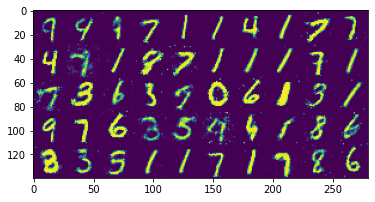

In [146]:
plt.imshow(y)